In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

# themes and appearance
sns.set_theme()

# jupyter notebook full-width display
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# no text wrapping
display(HTML("<style>.dataframe td { white-space: nowrap; }</style>"))

# pandas formatting
pd.set_option('display.float_format', '{:.3f}'.format)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 400)
pd.set_option('display.max_colwidth', 400)

In [2]:
# import data

# training data
df_train = pd.read_pickle('data/df_clean.pickle')[['song', 'artist', 'chord_progression_C']].rename({'chord_progression_C': 'chord_progression'}, axis=1)
df_train = df_train[(df_train.chord_progression.apply(len) > 1) & (df_train.chord_progression.apply(len) < 9)].reset_index(drop=True)
len_dataset = df_train.shape[0]

# data predicted from transformer models
df_m1k = pd.read_pickle('data/df_m1k.pickle').iloc[0:len_dataset].reset_index(drop=True)
df_m10k = pd.read_pickle('data/df_m10k.pickle').iloc[0:len_dataset].reset_index(drop=True)
df_m4 = pd.read_pickle('data/df_m4.pickle').iloc[0:len_dataset].reset_index(drop=True)
df_m4u = pd.read_pickle('data/df_m4u.pickle').iloc[0:len_dataset].reset_index(drop=True)

In [3]:
def how_big():
    # this is slow, but doesn't break everything by converting datatypes in place
    print(
        df_m1k.chord_progression.sort_values().value_counts().shape[0],
        df_m10k.chord_progression.sort_values().value_counts().shape[0],
        df_m4.chord_progression.sort_values().value_counts().shape[0],
        df_m4u.chord_progression.sort_values().value_counts().shape[0]
    )
    
how_big()

4384 3366 4084 5824


In [4]:
# (
#     df_m1k.value_counts('chord_progression').shape[0], 
#     df_m10k.value_counts('chord_progression').shape[0], 
#     df_m4.value_counts('chord_progression').shape[0], 
#     df_m4u.value_counts('chord_progression').shape[0]
# )

In [5]:
# # is astype('str') acting inplace? yes, what the hell?
# (
#     df_m1k.chord_progression.astype('str').value_counts('chord_progression').shape[0], 
#     df_m10k.chord_progression.astype('str').value_counts('chord_progression').shape[0], 
#     df_m4.chord_progression.astype('str').value_counts('chord_progression').shape[0], 
#     df_m4u.chord_progression.astype('str').value_counts('chord_progression').shape[0]
# )

In [6]:
# loop through and replace duplicated progressions with half until no duplicates are left
for _ in range(100):
    counter = 0
    for i, row in df.iterrows():
        chords = row['chord_progression']
        if len(chords) == 1:
            continue
        if chords[:len(chords)//2] == chords[len(chords)//2:]:
            df.at[i, 'chord_progression'] = chords[:len(chords)//2]
            counter += 1
    if counter == 0:
        break

# update progressions to remove repeated chords
def remove_repeated_chords(progression):
    clean_progression = [progression[0]]
    for chord in progression[1:]:
        if chord != clean_progression[-1]:
            clean_progression.append(chord)
    return clean_progression

In [13]:
df_m1k = pd.DataFrame(df_m1k['chord_progression'].apply(lambda row: remove_repeated_chords(row)))
df_m10k = pd.DataFrame(df_m10k['chord_progression'].apply(lambda row: remove_repeated_chords(row)))
df_m4 = pd.DataFrame(df_m4['chord_progression'].apply(lambda row: remove_repeated_chords(row)))
df_m4u = pd.DataFrame(df_m4u['chord_progression'].apply(lambda row: remove_repeated_chords(row)))

In [14]:
how_big()

4239 3298 3973 5623


In [17]:
df_m10k.iloc[1497]

chord_progression    [Am, G, C, G, Am, G, C, G]
Name: 1497, dtype: object

## Most Popular Chord Progressions

In [3]:
def top_progressions(dataframe, name='', n=99999):
    df = pd.DataFrame(dataframe.chord_progression.astype('str').value_counts().head(n)).reset_index()
    df['chord_progression'] = df['chord_progression'].replace("['\[\],]", '', regex=True)
    return df.rename({'count': f'{name}'}, axis=1)


In [4]:
def combine_counts():
    df = top_progressions(df_train, 'train_counts')
    
    df1 = top_progressions(df_m1k, 'm1k_counts')
    df2 = top_progressions(df_m10k, 'm10k_counts')
    df3 = top_progressions(df_m4, 'm4_counts')
    df4 = top_progressions(df_m4u, 'm4u_counts')
    
    for d in [df1, df2, df3, df4]:
        df = pd.merge(df, d, on='chord_progression', how='outer')
    
    numeric_columns = [x for x in df.columns if x != 'chord_progression']
    df[numeric_columns] = df[numeric_columns].astype('Int64')
    df['total_counts'] = df[numeric_columns].sum(axis=1)
    
    return df.sort_values('total_counts', ascending=False).reset_index(drop=True)


In [5]:
# top chord progressions by method
progression_counts = combine_counts().drop('total_counts', axis=1).fillna(0)

display(progression_counts.head())
display(progression_counts.tail())

,chord_progression,train_counts,m1k_counts,m10k_counts,m4_counts,m4u_counts
0,C G Am F,424,542,631,410,226
1,Am F C G,430,416,452,495,249
2,F C G,316,340,249,326,392
3,F G C,201,265,207,244,244
4,G F C,203,258,216,236,179


,chord_progression,train_counts,m1k_counts,m10k_counts,m4_counts,m4u_counts
13455,Csus2 C Csus4 C Csus4,0,1,0,0,0
13456,Am Am6 Am Dm,0,1,0,0,0
13457,F C F C G7,0,1,0,0,0
13458,Am7 Dmaj7,0,1,0,0,0
13459,C F Dm Am C F,0,0,0,0,1


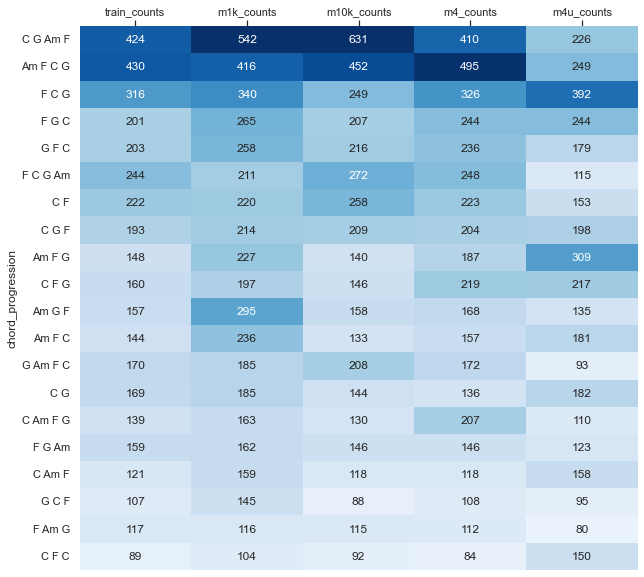

In [6]:
# plot as a heatmap

# how many chord progressions to plot
top_n = 20

plt.figure(figsize=(10, top_n//2))
fig = sns.heatmap(
    progression_counts.head(top_n).set_index('chord_progression').astype(float), 
    cmap='Blues', 
    annot=True, 
    fmt='g', 
    cbar=False, 
    vmin=50, 
    vmax=500
)
fig.xaxis.tick_top()
plt.show()

## Chord Progressions Not In Training Set

In [7]:
# mostly dominated by the underfit model (is it more "creative"?)
unique = progression_counts[progression_counts.train_counts==0]
unique.head(20)

,chord_progression,train_counts,m1k_counts,m10k_counts,m4_counts,m4u_counts
292,G F C G F C,0,19,0,14,1
315,G C,0,4,0,0,27
389,F G F G,0,9,0,8,8
413,G C Am,0,2,0,1,20
419,G C G,0,1,0,0,22
427,F C,0,10,0,2,10
474,C G Am Dm,0,3,1,5,11
492,G Am,0,1,1,2,15
496,F C Am,0,0,0,0,19
508,C Am C Am,0,9,2,4,3


In [8]:
# what about the top 10 from the underfit model
unique.sort_values('m4u_counts', ascending=False).head(10)

,chord_progression,train_counts,m1k_counts,m10k_counts,m4_counts,m4u_counts
315,G C,0,4,0,0,27
419,G C G,0,1,0,0,22
413,G C Am,0,2,0,1,20
496,F C Am,0,0,0,0,19
492,G Am,0,1,1,2,15
737,F Am,0,0,0,0,12
654,Dm F,0,2,0,0,12
647,Am C Am F,0,0,1,1,12
617,C C G,0,1,1,1,12
474,C G Am Dm,0,3,1,5,11


In [9]:
# let's check the overfit model (it predicts common pop progressions more often, is it more "cheesy"?)
unique.sort_values('m10k_counts', ascending=False).head(10)

,chord_progression,train_counts,m1k_counts,m10k_counts,m4_counts,m4u_counts
679,C Am Em F G,0,5,6,1,1
1387,C F C Dm G7,0,1,5,0,0
1074,Am Dm C Am,0,1,5,0,2
1565,C G C Am G F,0,0,5,0,0
1415,G Em C F,0,0,5,0,1
1757,C F Gsus4 Am Gsus4,0,0,4,0,0
911,C F G C Am,0,2,4,0,3
1750,C G Em C G Em,0,0,4,0,0
1754,C C4 C C4,0,0,4,0,0
1237,C G Am F C G Dm,0,0,4,1,1


In [18]:
df_m4u['chord_progression'].iloc[1497]

['G', 'Cadd9', 'C', 'Am7', 'F', 'C', 'C']

"['Am', 'G', 'F', 'C']"

['G', 'Cadd9', 'C', 'Am7', 'F', 'C']

In [13]:
df_m1k.apply(lambda row: remove_repeated_chords(row))

,chord_progression
0,"['Am', 'F', 'C', 'Am', 'F', 'C']"
1,"['G', 'C', 'G', 'Am', 'F']"
2,"['Am', 'C', 'F', 'G']"
3,"['G', 'F', 'C', 'Am']"
4,"['Am', 'G', 'F', 'C']"
...,...
16236,"['G', 'Em', 'Am', 'F', 'C']"
16237,"['F', 'C', 'G']"
16238,"['F', 'C', 'F', 'Am', 'Gsus4']"
16239,"['C', 'Dm', 'F']"


In [47]:
progression = ['C', 'C', 'Dm', 'C']
remove_repeated_chords(progression)

['C', 'Dm', 'C']

chord_progression    ['C', 'C', 'Dm', 'C']
Name: 1497, dtype: object

In [38]:
i, j = 11600, 20
df_m4u.sort_values('chord_progression').tail(i).head(j)

,chord_progression
1497,"['C', 'C', 'Dm', 'C']"
12607,"['C', 'C', 'Dm', 'Dm', 'F']"
3681,"['C', 'C', 'Dm', 'F', 'Am', 'G']"
4137,"['C', 'C', 'Dm', 'G']"
14208,"['C', 'C', 'Dm', 'G7', 'C']"
14691,"['C', 'C', 'Dm7b5']"
11706,"['C', 'C', 'E6', 'C', 'G']"
7331,"['C', 'C', 'Em', 'F', 'Am', 'G']"
16034,"['C', 'C', 'Em', 'F', 'C', 'G', 'F']"
6298,"['C', 'C', 'Em', 'F']"


In [40]:
# 11618  ['C', 'C', 'Em']
df_m4u.iloc[[11618]]

,chord_progression
11618,"['C', 'C', 'Em']"


In [46]:
df_m4u[['chord_progression']].apply(lambda row: remove_repeated_chords(row)).iloc[11618]

chord_progression    ['C', 'C', 'Em']
Name: 11618, dtype: object

In [14]:
df_m4u.chord_progression.value_counts().shape[0]

5824

In [16]:
df_m4u = df_m4u.apply(lambda row: remove_repeated_chords(row))

In [17]:
df_m4u.chord_progression.value_counts().shape[0]

5824

In [15]:
df_m4u

,chord_progression
0,"['Am', 'G', 'F', 'C']"
1,"['F', 'G', 'C']"
2,"['Am', 'F', 'C']"
3,"['Am', 'C', 'Em']"
4,"['C', 'G', 'F', 'C', 'F']"
...,...
16343,"['Am', 'F', 'G']"
16344,"['C', 'F', 'Dm', 'Am', 'C', 'F']"
16345,"['Em', 'Am', 'Em', 'F']"
16346,"['C', 'G', 'Am', 'F']"


In [18]:
df_m4u

,chord_progression
0,"['Am', 'G', 'F', 'C']"
1,"['F', 'G', 'C']"
2,"['Am', 'F', 'C']"
3,"['Am', 'C', 'Em']"
4,"['C', 'G', 'F', 'C', 'F']"
...,...
16285,"['Am', 'F', 'G']"
16286,"['C', 'F', 'Dm', 'Am', 'C', 'F']"
16287,"['Em', 'Am', 'Em', 'F']"
16288,"['C', 'G', 'Am', 'F']"
